# Incremental decision trees in river: the Hoeffding Tree case


Decision trees (DT) are popular learning models due to their inherently simplicity, flexibility and self-explainable structure. Moreover, when aggregated in ensembles, high predictive power might be achieved. Bagging and gradient boosting-based tree ensembles are very popular solutions in competition platforms such as Kaggle, and also among researchers.

Although fairly lightweight, traditional batch DTs cannot cope with data stream mining/online learning requirements, as they do multiple passes over the data and have to be retrained from scratch every time a new observation appears.

The data stream literature has plenty of incremental DT (iDT) families that are better suited to online learning. Nonetheless, Hoeffding Trees (HT) are historically the most popular family of iDTs to date. In fact, HTs have some nice properties:

- one-pass learning regime;
- theoretical guarantees to converge to the batch DT model given enough observations and a stationary data distribution;
- small memory and running time footprint (in most cases);
- some of their variations can deal with non-stationary distributions.

And the previous list goes on and on. Besides that, HTs also have the same advantages as batch DTs (`C4.5`/`J48`, `CART`, `M5`, etc.) do. We can inspect the structure of a HT to understand how decisions were made, which is a nice feature to have in online learning tasks.

In River, HTs are first-class citizens, so we have multiple realizations of this framework that are suited to different learning tasks and scenarios.

This brief introduction to HT does not aims at being extensive nor delving into algorithmic or implementation details of the HTs. Instead, we intend to provide a high-level overview of the HTs as they are envisioned in River, as well as their shared properties and important hyperparameters.

In this guide, we are going to:

1. summarize the differences accross the multiple HT versions available;
2. learn how to inspect tree models;
3. learn how to manage the memory usage of HTs;
4. compare numerical tree splitters and understand their impact on the iDT induction process.

Well, without further ado, let's go! 


**First things first, we are going to start with some imports.**

In [1]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

## 1. Trees, trees everywhere: gardening 101 with river

At first glance, the amount of iDT algorithms in River might seem too much to handle, but in reality the distinction among them is easy to grasp. To facilitate our lives, here's a neat table listing the available HT models and summarizing their differences:


| Name | Acronym | Task | Non-stationary? | Comments | Source |
| :- | :-: | :- | :-: | :- | :-: |
| Hoeffding Tree Classifier | HTC | Classification | No | Basic HT for classification tasks | [[1]](https://dl.acm.org/doi/pdf/10.1145/347090.347107)
| Hoeffding Adaptive Tree Classifier | HATC | Classification | Yes | Modifies HTC by adding an instance of ADWIN to each node to detect and react to drift detection | [[2]](https://link.springer.com/chapter/10.1007/978-3-642-03915-7_22)
| Extremely Fast Decision Tree Classifier | EFDT | Classification | No | Deploys split decisions as soon as possible and periodically revisit decisions and redo them if necessary. Not as fast in practice as the name implies, but it tends to converge faster than HTC to the model generated by a batch DT | [[3]](https://dl.acm.org/doi/abs/10.1145/3219819.3220005)
| Hoeffding Tree Regressor | HTR | Regression | No | Basic HT for regression tasks. It is an adaptation of the [FIRT/FIMT](https://link.springer.com/article/10.1007/s10618-010-0201-y) algorithm that bears some semblance to HTC | [[4]](https://link.springer.com/article/10.1007/s10618-010-0201-y)
| Hoeffding Adaptive Tree Regressor | HATR | Regression | Yes | Modifies HTR by adding an instance of ADWIN to each node to detect and react to drift detection | -
| incremental Structured-Output Prediction Tree Regressor| iSOUPT | Multi-target regression | No | Multi-target version of HTR | [[5]](https://link.springer.com/article/10.1007/s10844-017-0462-7)
| Label Combination Hoeffding Tree Classifier | LCHTC | Multi-label classification | No | Creates a numerical code for each combination of the binary labels and uses HTC to learn from this encoded representation. At prediction time, decodes the modified representation to obtain the original label set |  -


As we can see, although their application fields might overlap sometimes, the HT variations have specific situations in which they are better suited to work. Moreover, in River we provide a standardized API access to all the HT variants since they share many properties in common.

## 2. How to inspect tree models?

We provide a handful of tools to inspect trained HTs in River. Here, we will provide some examples of how to access their inner structures, get useful information, and plot the iDT structure.

Firstly, let's pick a toy dataset from which our tree will learn from. Here we are going to focus on the classification case, but the same operations apply to other learning tasks. We will select the `Phishing` dataset from the `datasets` module to exemplify the HTs' capabilities.

In [2]:
dataset = datasets.Phishing()
dataset

Phishing websites.

This dataset contains features from web pages that are classified as phishing or not.

    Name  Phishing                                                          
    Task  Binary classification                                             
 Samples  1,250                                                             
Features  9                                                                 
  Sparse  False                                                             
    Path  /Users/max/projects/online-ml/river/river/datasets/phishing.csv.gz

We are going to train an instance of `HoeffdingTreeClassifier` using this dataset. As everything else in River, training an iDT is a piece of cake!

In [3]:
%%time

model = tree.HoeffdingTreeClassifier(grace_period=50)

for x, y in dataset:
    model.learn_one(x, y)
    
model

CPU times: user 37.6 ms, sys: 569 µs, total: 38.2 ms
Wall time: 39.1 ms


HoeffdingTreeClassifier (
  grace_period=50
  max_depth=inf
  split_criterion="info_gain"
  delta=1e-07
  tau=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
  splitter=GaussianSplitter (
    n_splits=10
  )
  binary_split=False
  min_branch_fraction=0.01
  max_share_to_split=0.99
  max_size=100.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

That's it! We are not going to enter into details about some of the available parameters of HTC here. The user can refer to the documentation page for more information about that. Let's talk about model inspection :D

At any time, we can easily get some statistics about our trained model by using the `summary` property:

In [4]:
model.summary

{'n_nodes': 5,
 'n_branches': 2,
 'n_leaves': 3,
 'n_active_leaves': 3,
 'n_inactive_leaves': 0,
 'height': 3,
 'total_observed_weight': 1250.0}

This property show us the internal structure of the tree, including data concerning the memory-management routines that we are going to check later in this guide. We can also get a representation of the tree model as a `pandas.DataFrame` object:

In [5]:
model.to_dataframe().iloc[:5, :5]

,parent,is_leaf,depth,stats,feature
node,,,,,
0,<NA>,False,0,"{True: 260.0, False: 390.0}",empty_server_form_handler
1,0,True,1,"{True: 443.4163997711022, False: 59.8769131081...",NaN
2,0,False,1,"{True: 71.58360022889781, False: 404.123086891...",popup_window
3,2,True,2,"{False: 31.426538522574834, True: 33.0}",NaN
4,2,True,2,"{False: 250.57346147742516, True: 6.0}",NaN


Hmm, maybe not the clearest of the representations. What about drawing the tree structure instead?

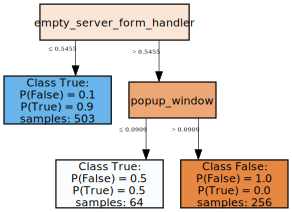

In [6]:
model.draw()

Much better, huh?

Lastly, we can check how the tree predicts one specific instance by using the `debug_one` method:

In [7]:
x, y = next(iter(dataset))  # Let's select the first example in the stream
x, y

({'empty_server_form_handler': 0.0,
  'popup_window': 0.0,
  'https': 0.0,
  'request_from_other_domain': 0.0,
  'anchor_from_other_domain': 0.0,
  'is_popular': 0.5,
  'long_url': 1.0,
  'age_of_domain': 1,
  'ip_in_url': 1},
 True)

In [8]:
print(model.debug_one(x))

empty_server_form_handler ≤ 0.5454545454545454
Class True:
	P(False) = 0.1
	P(True) = 0.9



Our tree got this one right! The method `debug_one` is especially useful when we are dealing with a big tree model where drawing might not be the wisest of the choices (we will end up with a tree chart that has too much information to visually understand).

 **Some additional hints:**

- the `max_depth` parameter is our friend when building HTs that need to be constantly inspected. This parameter, which is available for every HT variant, triggers a pre-pruning mechanism that stops tree growth when the given depth is reached.
- we can also limit the depth when using the `draw` method.
- in the case of tree ensembles, individual trees can be accessed using the `[index]` operator. Then, the same set of inspection tools are available to play with!

## 3. Advanced gardening with river: grab your pruning shears and let's limit memory usage

Online learning is well-suited to highly scalable processing centers with petabytes of data arriving intermittently, but it can also work with Internet of Things (IoT) devices operating at low power and with limited processing capability. Hence, making sure our trees are not going to use too much memory is a nice feature that can impact on both energy usage and the running time. HTs have memory-management routines that put the user in the control of computational resources that are available.

In this brief guide, we are going to use a regression tree, since this kind of iDT typically spends more memory than the classification counterparts. However, the user can control the memory usage in the exact same way in River, regardless of the HT variant!

We will rely on the `Friedman` synthetic dataset (data generator) from the `synth` module in our evaluation. Since data generators can produce instances indefinitely, we will select a sample of size 10K for our tests.

We are almost ready to go. Let's first define a simple function that plots the results obtained from a given dataset, metric and 

In [9]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__

    # To make the generated data reusable
    dataset = list(dataset)
    fig, ax = plt.subplots(figsize=(10, 5), nrows=3, dpi=300)
    for model_name, model in models.items():
        step = []
        error = []
        r_time = []
        memory = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=True, measure_memory=True, step=100
        ):
            step.append(checkpoint["Step"])
            error.append(checkpoint[metric_name].get())

            # Convert timedelta object into seconds
            r_time.append(checkpoint["Time"].total_seconds())
            # Make sure the memory measurements are in MB
            raw_memory = checkpoint["Memory"]
            memory.append(raw_memory * 2**-20)

        ax[0].plot(step, error, label=model_name)
        ax[1].plot(step, r_time, label=model_name)
        ax[2].plot(step, memory, label=model_name)
    
    ax[0].set_ylabel(metric_name)
    ax[1].set_ylabel('Time (seconds)')
    ax[2].set_ylabel('Memory (MB)')
    ax[2].set_xlabel('Instances')
    
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)

    ax[0].legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.25),
        ncol=3, fancybox=True, shadow=True
    )
    plt.tight_layout()
    plt.close()

    return fig

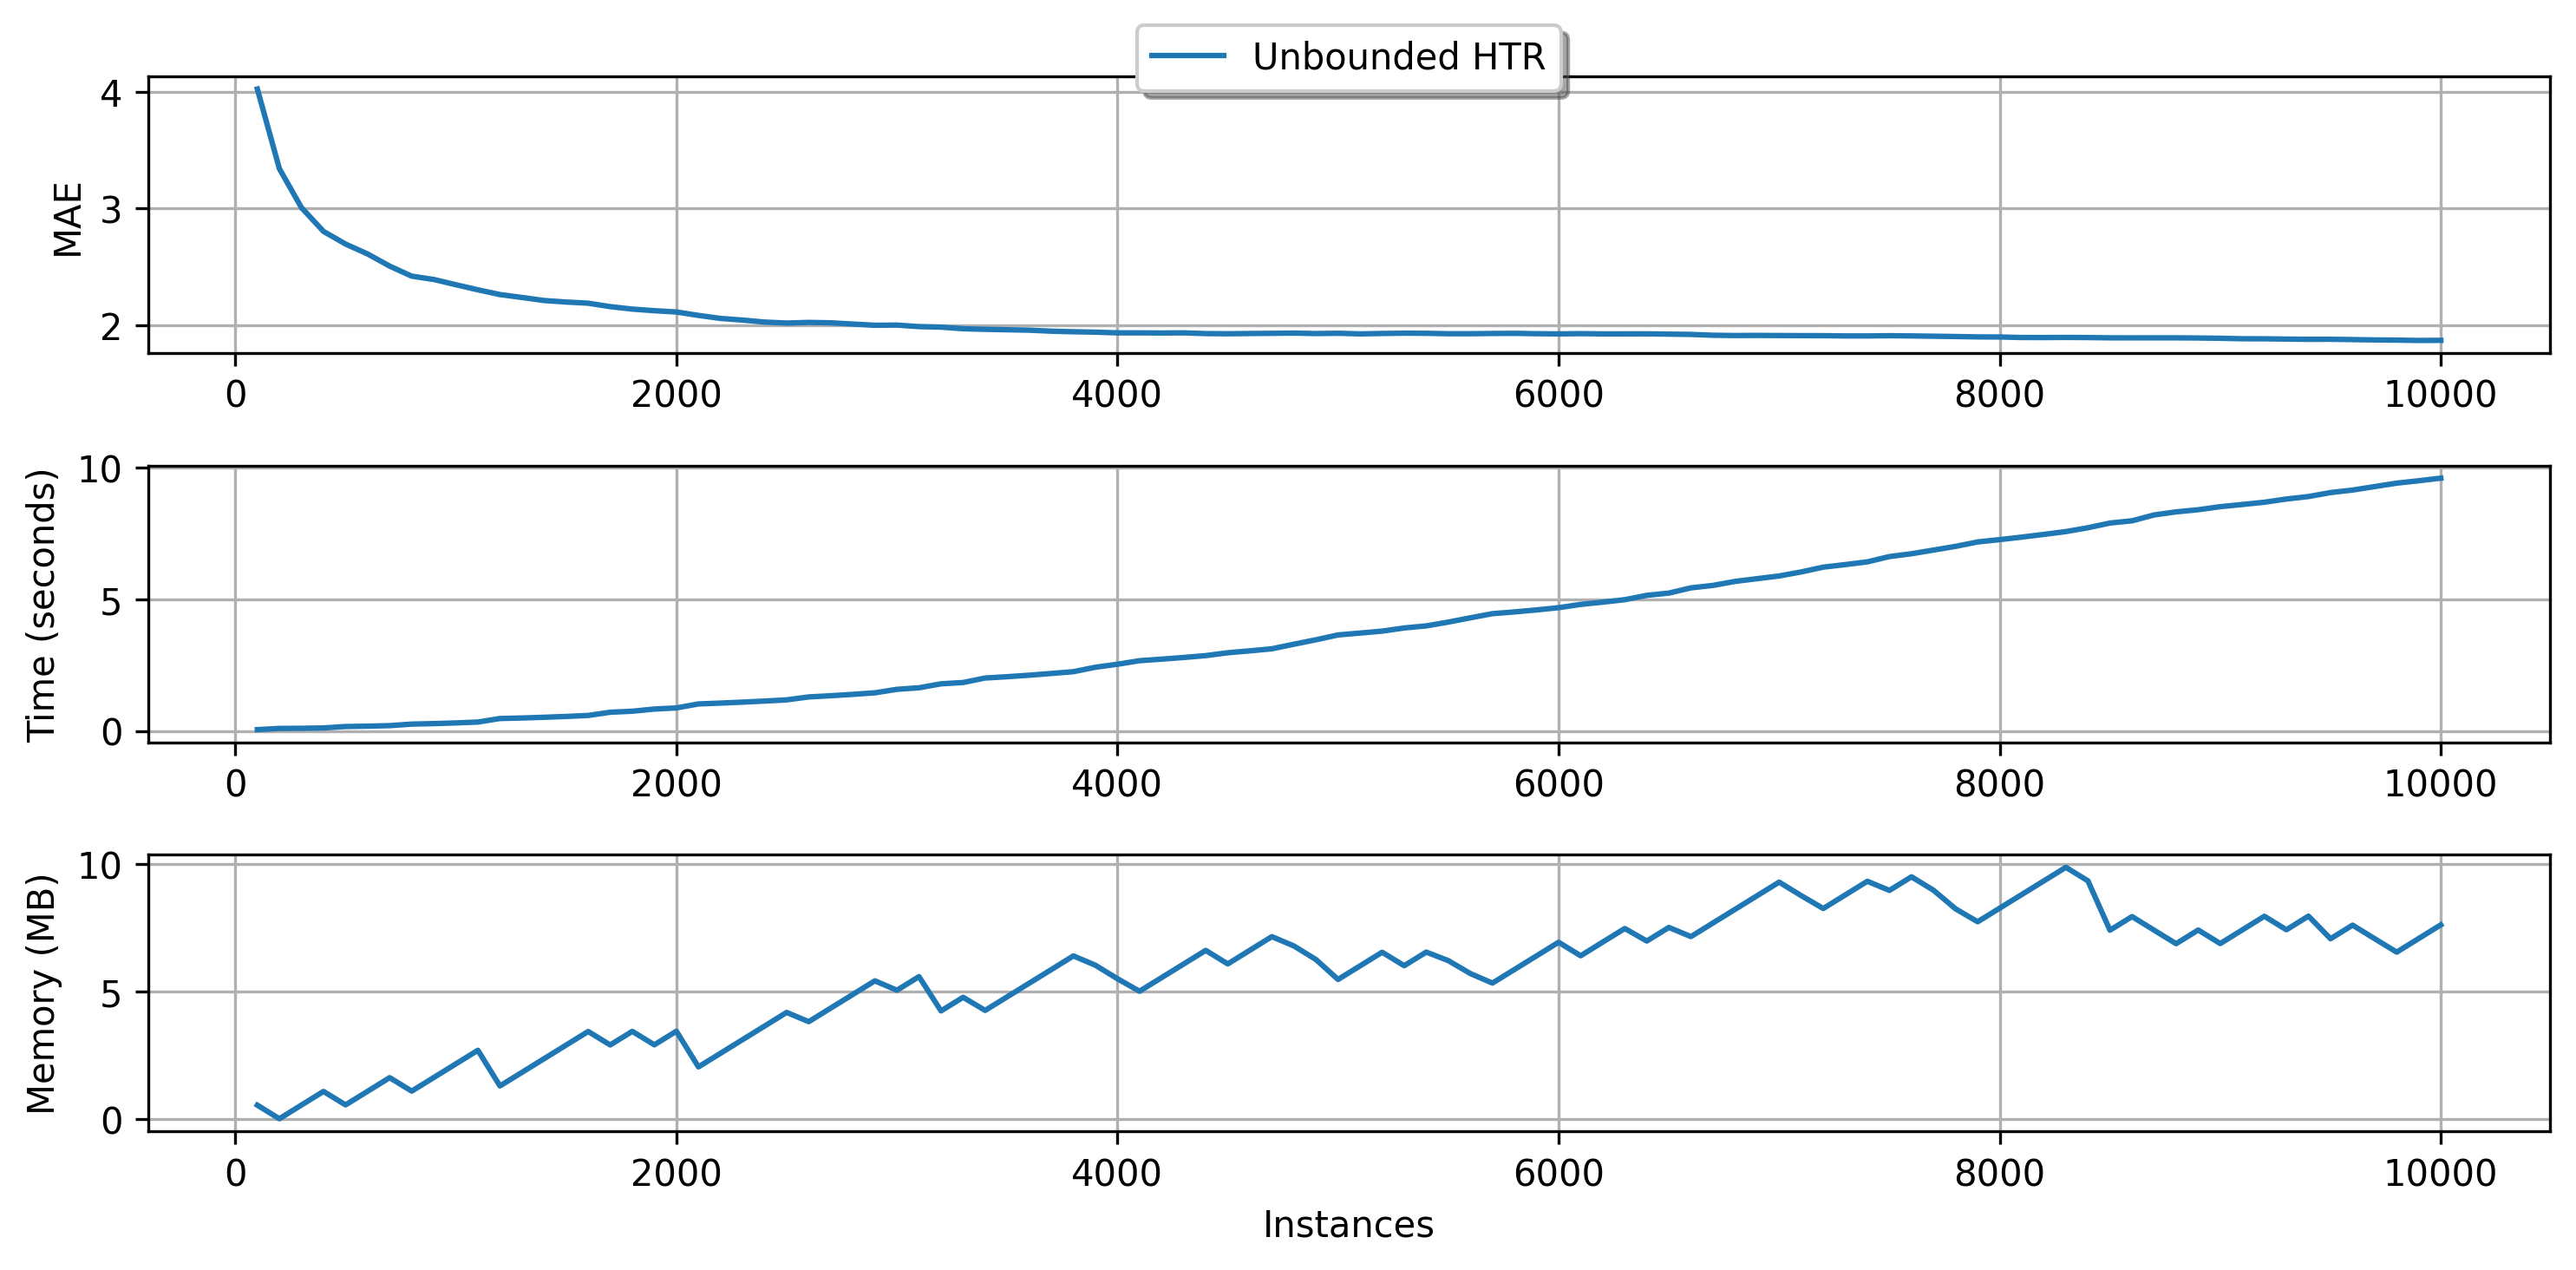

In [10]:
plot_performance(
    synth.Friedman(seed=42).take(10_000),
    metrics.MAE(),
    {
        "Unbounded HTR": (
            preprocessing.StandardScaler() |
            tree.HoeffdingTreeRegressor(splitter=tree.splitter.EBSTSplitter())
        )
    }
)

In our example we use the `EBSTSplitter`, which is going to discussed later. For now, is enough to know that it is a mechanism to evaluate split candidates in the trees.

As we can see, our tree uses almost 10 MB to keep its structure. Let's say we wanted to limit our memory usage to 5 MB. How could we do that?

Note that we are using a illustration case here. In real applications, data may be unbounded, so the trees might grow indefinitely.

HTs expose some parameters related to memory management. The user can refer to the documentation for more details on that matter. Here, we are going to focus on two parameters:

- `max_size`: determines the maximum amount of memory (in MB) that the HT can use.
- `memory_estimate_period`: intervals after which the memory-management is triggered.

We are going to limit our HTR to 5 MB and perform memory checks at intervals of 500 instances.

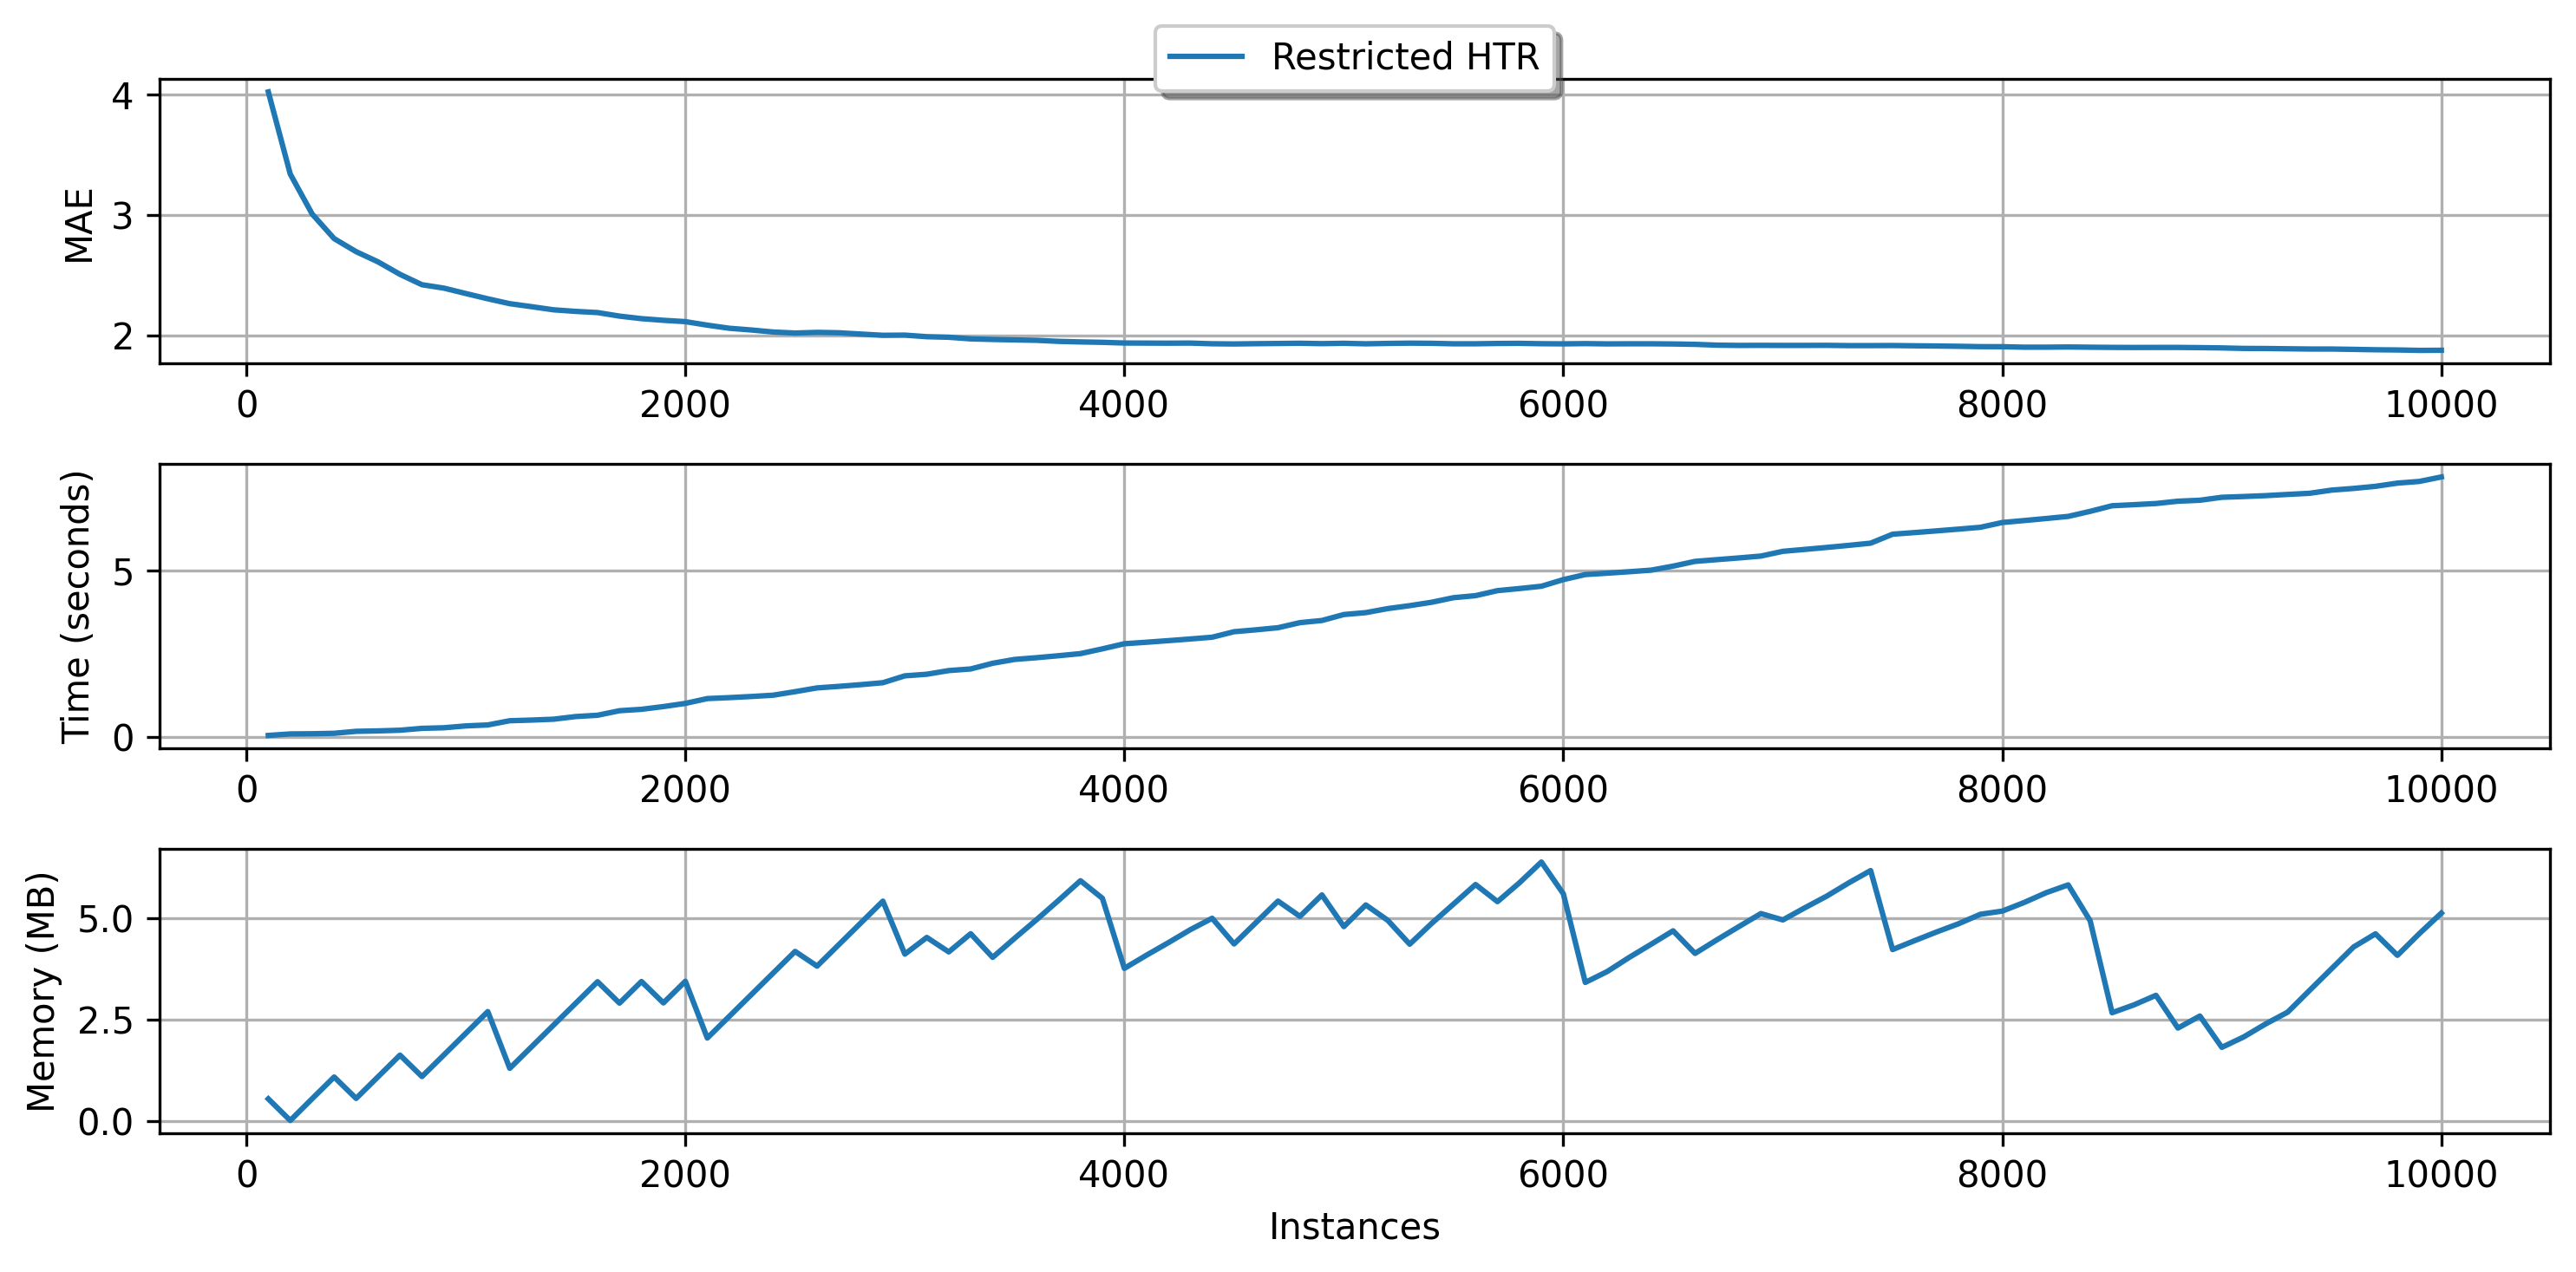

In [11]:
plot_performance(
    synth.Friedman(seed=42).take(10_000),
    metrics.MAE(),
    {
        "Restricted HTR": (
            preprocessing.StandardScaler()
            | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter(),
                max_size=5,
                memory_estimate_period=500
            )
        )
    }
)

Note that as soon the memory usage reaches the limit that we determined (at the memory check intervals), HTR starts managing its resource usage to reduce the size. As a consequence, the running time also decreases. For more accurate management, the intervals between memory checks should be decreased. This action, however, has costs since the tree stops the learning process to estimate its size and alter its own structure. Too frequent memory checks might end up result in a slow learning process. Besides, by using fewer resources, the predictive performance can be negatively impacted. So, use this tool with caution!

**But how that works at all?**

HTs monitor the incoming feature values to perform split attempts. To do so, they rely on a class of algorithms called *Attribute Observers* (AO) or *Splitters* (spoiler alert!). Each leaf node in an HT keeps one AO per incoming feature. After pre-determined intervals (`grace_period` parameter), leaves query their AOs for split candidates. Well, there are costs to monitor input features (mainly the numerical ones). In fact, AOs correspond to one of the most time and memory-consuming portions of the HTs. To manage memory usage, an HT firstly determines its least promising leaves, w.r.t. how likely they will be split. Then, these leaves' AOs are removed, and the tree nodes are said to be "deactivated." That's it! The deactivated leaves do not perform split attempts anymore, but they continue to be updated to provide responses. They will be kept as leaves as long as there are not available resources to enable tree growth. These leaves can be activated again (meaning that new AOs will be created for them) if there is available memory, so don't worry!

**Hint:** another indirect way to bound memory usage is to limit the tree depth. By default, the trees can grow indefinitely, but the `max_depth` parameter can control this behavior.

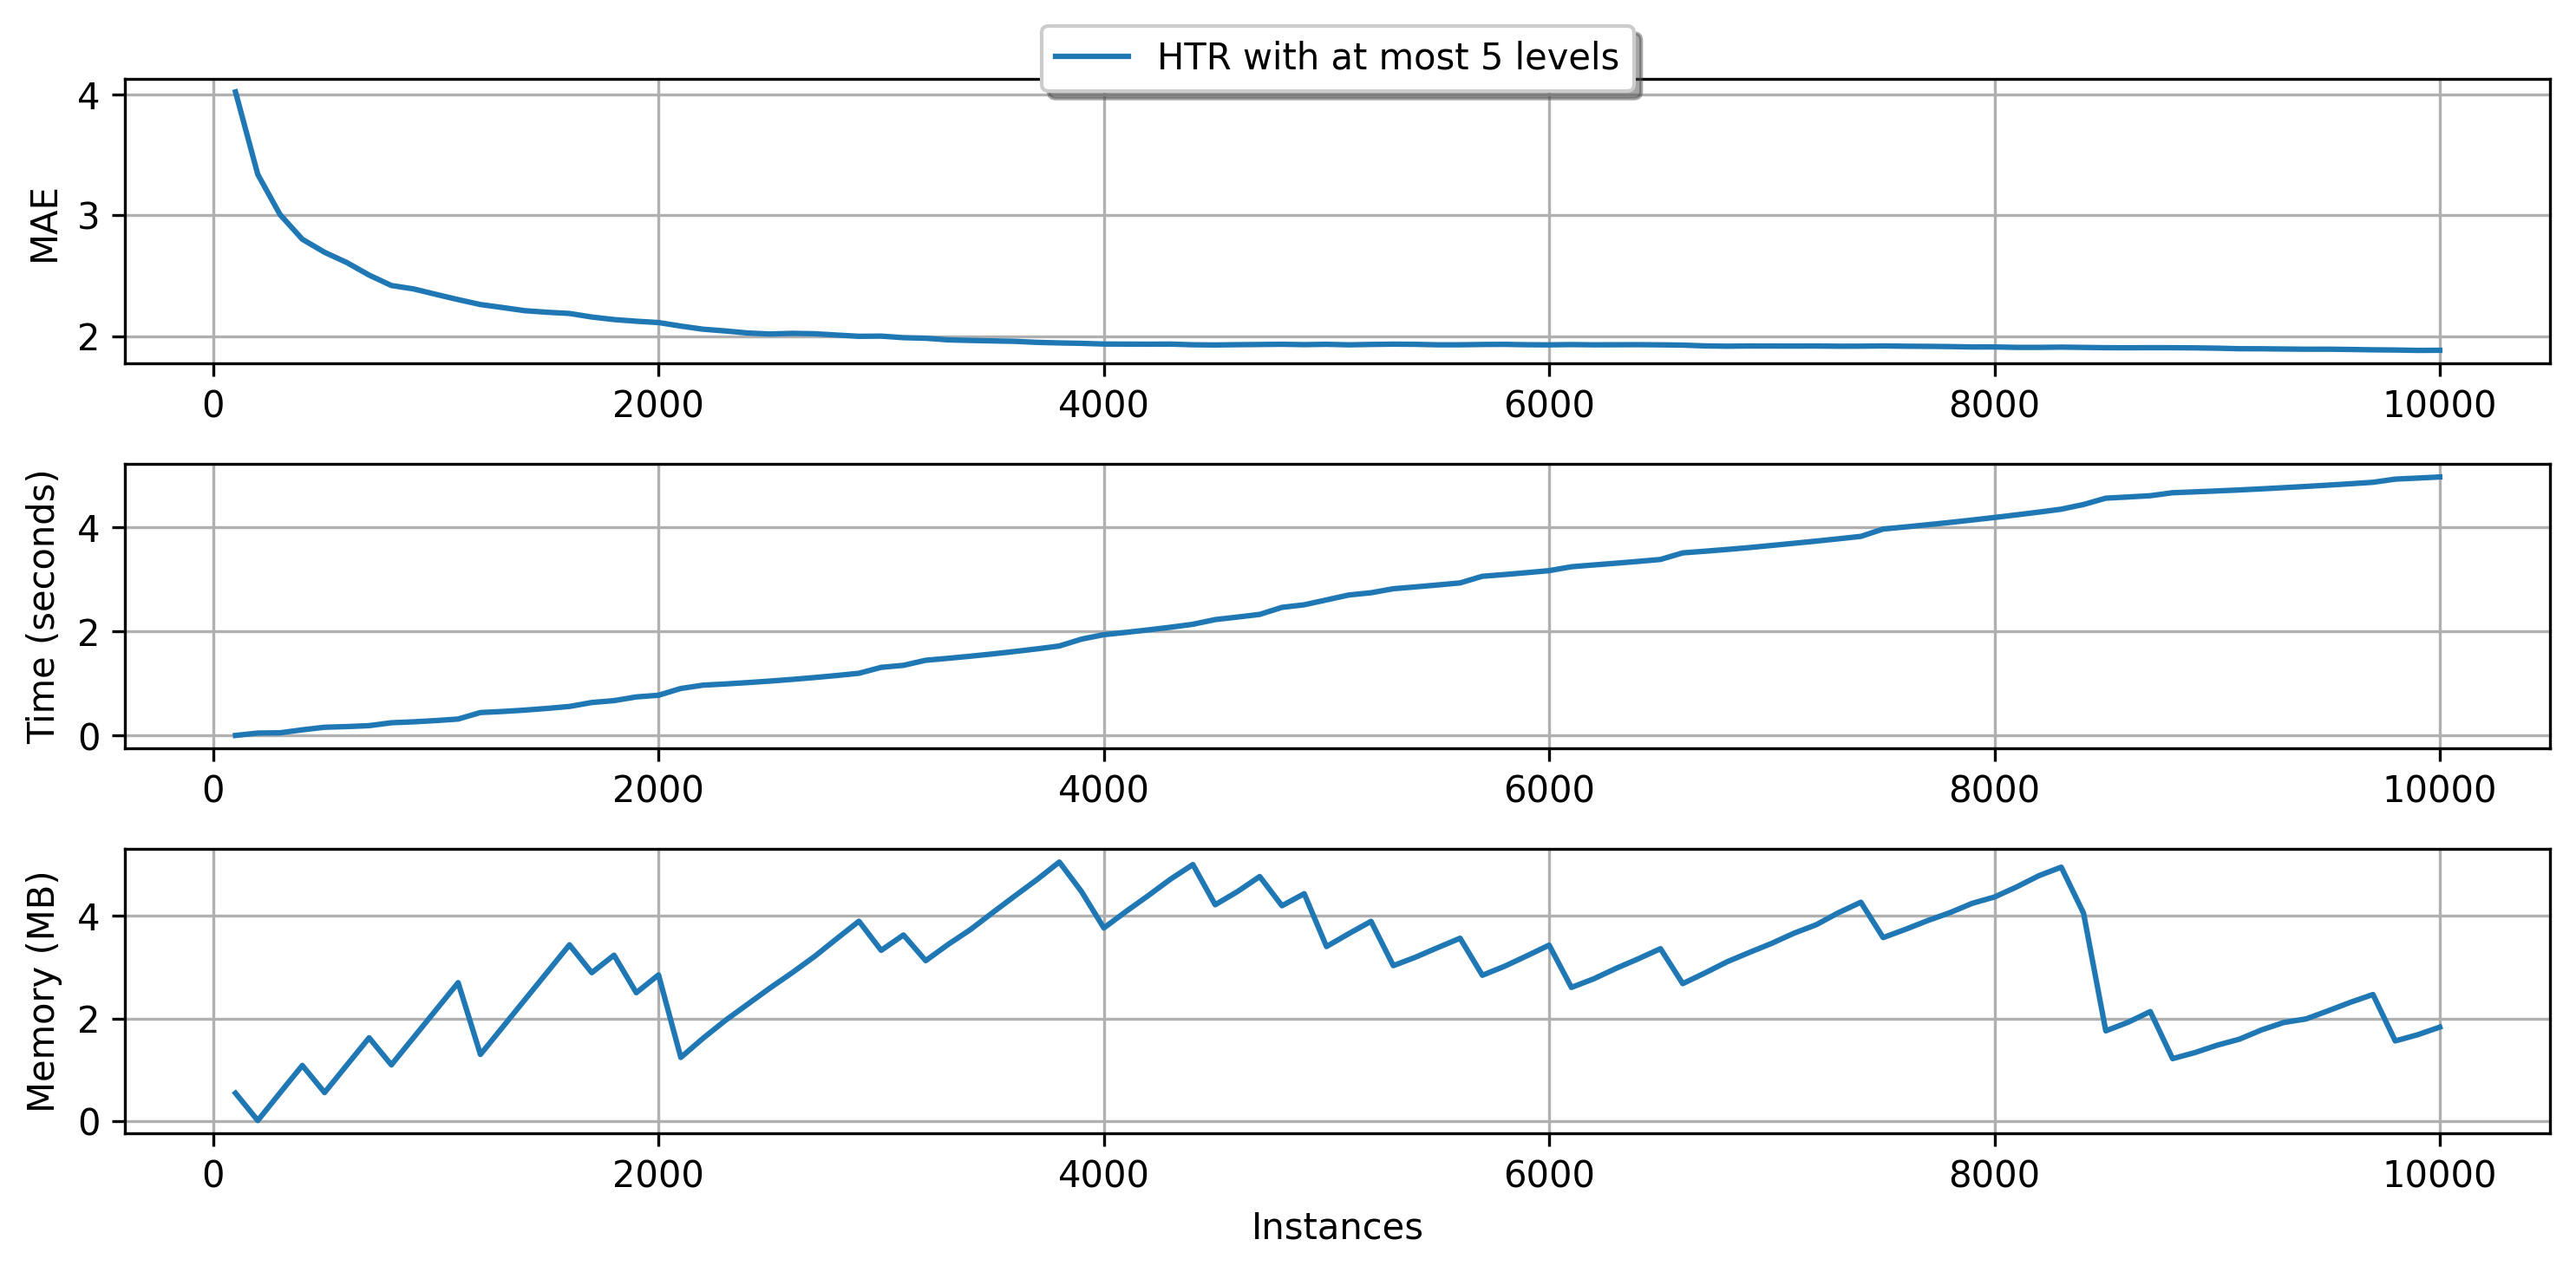

In [12]:
plot_performance(
    synth.Friedman(seed=42).take(10_000),
    metrics.MAE(),
    {
        "HTR with at most 5 levels": (
            preprocessing.StandardScaler()
            | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter(),
                max_depth=5
            )
        )
    }
)

## 4. Branching and growth: splitters, the heart of the trees

As previously stated, one of the core operations of iDT is, well, to grow. Plants and gardening-related jokes apart, growth in HTs is guided by their AOs or splitters, as mentioned in the end of Section 3. 

Nominal features can be easily monitored, since the feature partitions are well-defined beforehand. Numerical features, on the other hand, do not have an explicit best cut point. Still, numerical features are typically split by using a binary test: $\le$ or $>$. Therefore, numerical splitters must somehow summarize the incoming feature values and be able to evaluate the merit of split point candidates.

There are diverse strategies to monitor numerical features and choices related to them, including which data structure will be used to keep a summary of the incoming feature and also how many split points are going to be evaluated during split attempts. Again, this guide does not intend to be an exhaustive delve into the iDT subject. In fact, each of the following aspects of the iDTs could be considered a separate research area: AOs, intervals between split attempts, split heuristics (e.g., info gain, variance reduction, and so on), tree depth and max size, and much more!

Let's focus a bit into the AO matter. River provides a handful of splitters for classification and regression trees, which can be chosen using the parameter `splitter`. We will list the available tree splitters in the following sections and compare some of their chacteristics.

Some notation:

- $n$: Number of observations seen so far.
- $c$: the number of classes.
- $s$: the number of split points to evaluate (which means that this is a user-given parameter).
- $h$: the number of histogram bins or hash slots. Tipically, $h \ll n$.

### 4.1. Classification tree splitters

The following table summarizes the available classification splitters. The user might refer to the documentation of each splitter for more details about their functioning.


| Splitter | Description | Insertion | Memory | Split candidate query | Works with Naive Bayes leaves?
| :- | :- | :- | :-: | :-: | :-: |
| Exhaustive | Keeps all the observed input values and class counts in a Binary Search Tree (BST) | $O(\log n)$ (average) or $O(n)$ (worst case) | $O(n)$ | $O(n)$ | No |
| Histogram | Builds a histogram for each class in order to discretize the input feature | $O(\log h)$ | $O(c h)$ | $O(c h)$ | Yes |
| Gaussian | Approximates the class distributions using Gaussian distributions | $O(1)$ | $O(c)$ | $O(cs)$ | Yes |

Note that some of the splitters have configurable parameters that directly impact not only on their time and memory costs, but also on the final predictive performance. Examples:

- The number of split points can be configured in the Gaussian splitter. Increasing this number makes this splitter slower, but it also potentially increases the quality of the obtained query points, implying enhanced tree accuracy. 
- The number of stored bins can be selected in the Histogram splitter. Increasing this number increases the memory footprint and running time of this splitter, but it also potentially makes its split candidates more accurate and positively impacts on the tree's final predictive performance.

Next, we provide a brief comparison of the classification splitters using 10K instances of the Random RBF synthetic dataset. Note that the tree equiped with the Exhaustive splitter does not use Naive Bayes leaves.

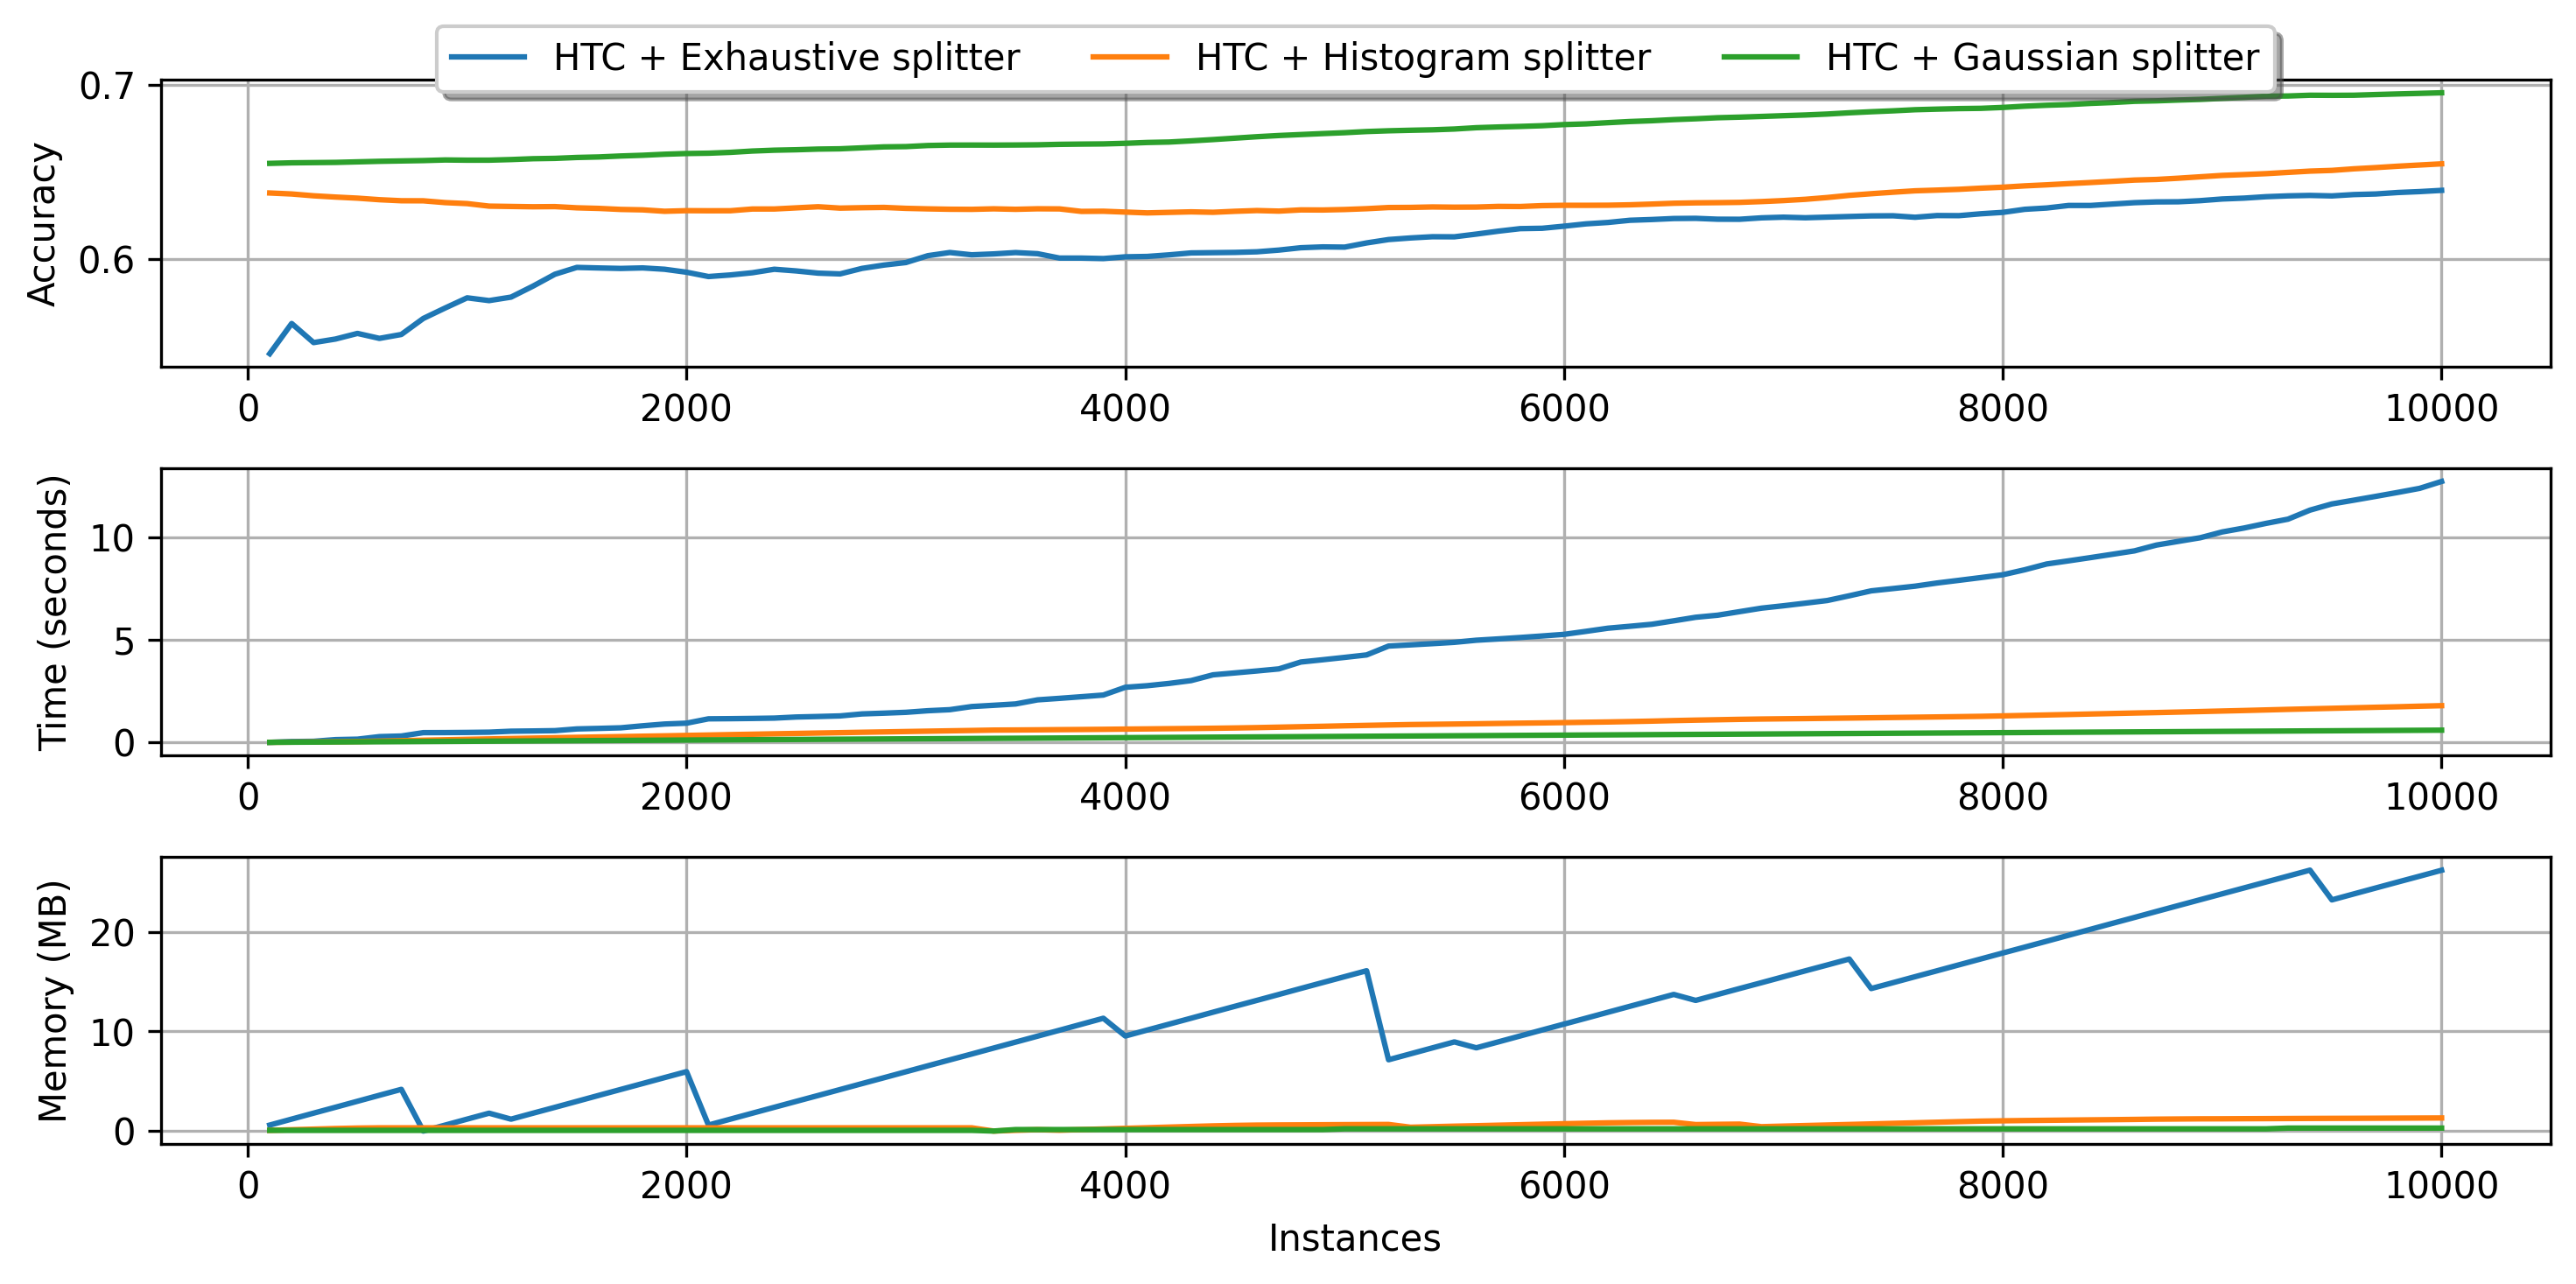

In [13]:
plot_performance(
    synth.RandomRBF(seed_model=7, seed_sample=42).take(10_000),
    metrics.Accuracy(),
    {
        "HTC + Exhaustive splitter": tree.HoeffdingTreeClassifier(
            splitter=tree.splitter.ExhaustiveSplitter(),
            leaf_prediction="mc"
        ),
        "HTC + Histogram splitter": tree.HoeffdingTreeClassifier(
            splitter=tree.splitter.HistogramSplitter()
        ),
        "HTC + Gaussian splitter": tree.HoeffdingTreeClassifier(
            splitter=tree.splitter.GaussianSplitter()
        )
    }
)

### 4.2 Regression tree splitters

The available regression tree splitters are summarized in the next table. The TE-BST costs are expressed in terms of $n^*$ because the number of stored elements can be smaller than or equal to $n$.

| Splitter | Description | Insertion | Memory | Split candidate query |
| :- | :- | :- | :-: | :-: |
| Extended Binary Search Tree (E-BST) | Stores all the observations and target statistics in a BST | $O(\log n)$ (average) or $O(n)$ (worst case) | $O(n)$ | $O(n)$ | 
| Truncated E-BST (TE-BST) | Rounds the incoming data before passing it to the BST | $O(\log n^*)$ (average) or $O(n^*)$ (worst case) | $O(n^*)$ | $O(n^*)$ |
| Quantization Observer (QO) | Uses a hash-like structure to quantize the incoming data | $O(1)$ | $O(h)$ | $O(h \log h)$ |


E-BST is an exhaustive algorithm, i.e., it works as batch solutions usually do, which might be prohibitive in real-world online scenarios. TE-BST and QO apply approximations to alleviate the costs involved in monitoring numerical data and performing split attempts. The number of desired decimal places to round the data (TE-BST) and the quantization radius (QO) are directly related to the running time, memory footprint, and error of the resulting tree model.

We present a brief comparison of the available regression tree splitters using the 10K instances of the Friedman synthetic dataset.

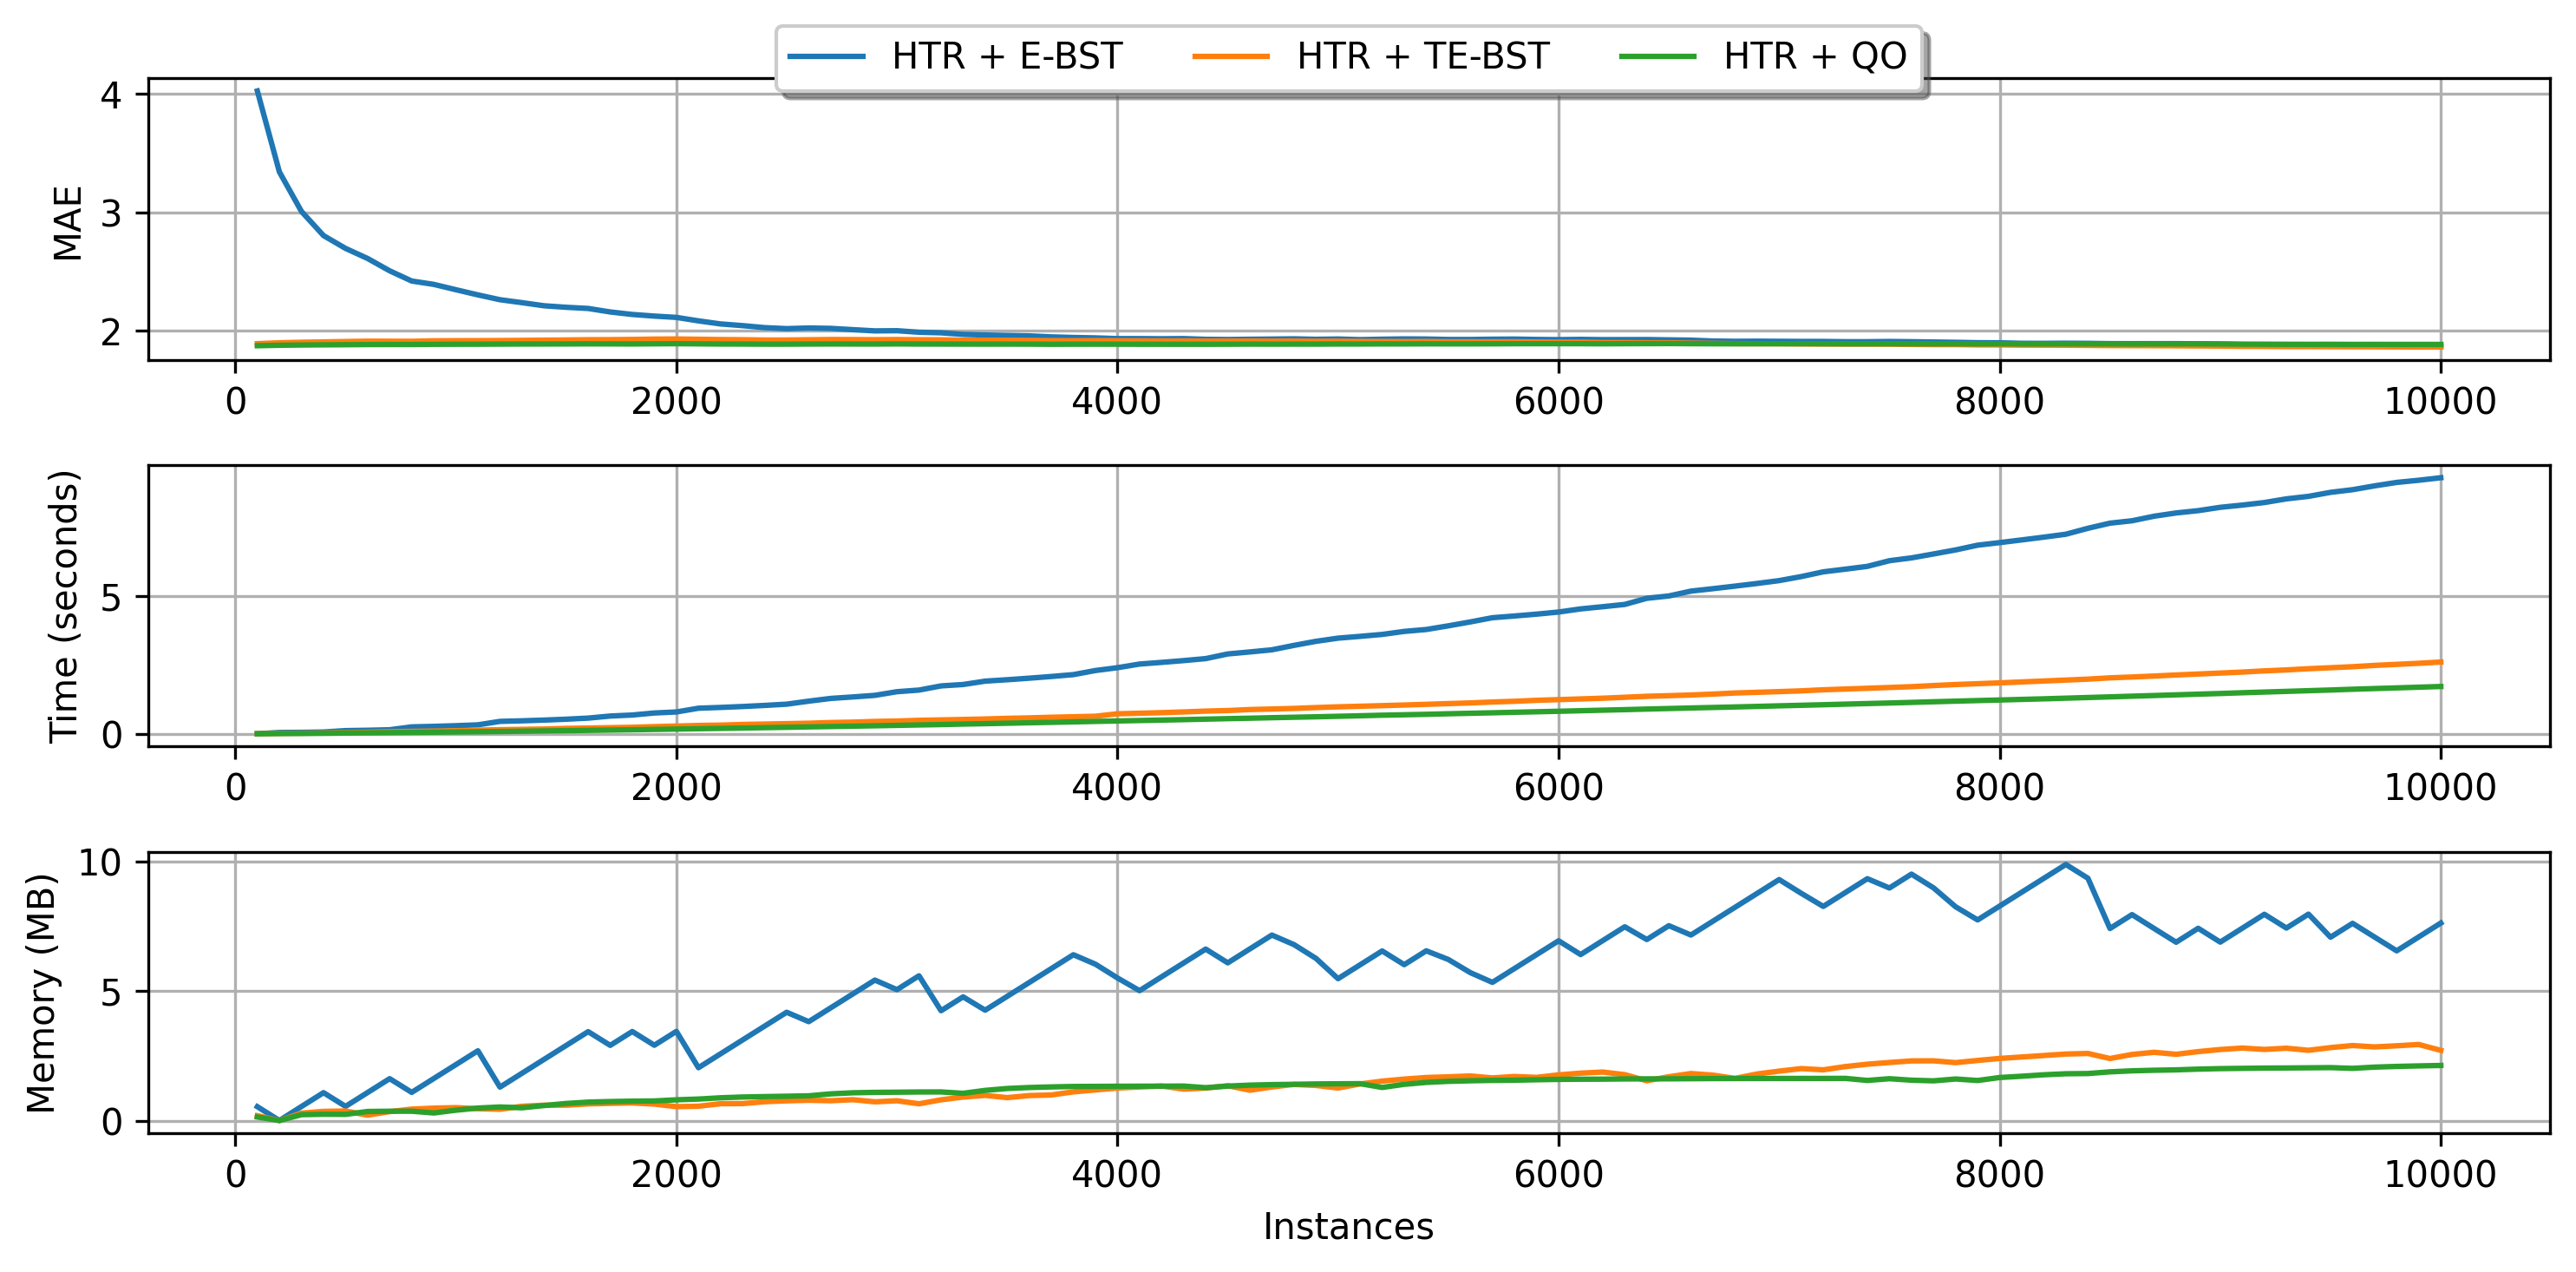

In [14]:
plot_performance(
    synth.Friedman(seed=42).take(10_000),
    metrics.MAE(),
    {
        "HTR + E-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter()
            )
        ),
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter()
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
        
    }
)

## Wrapping up

This guide provides a walkthrough in the HTs available in River. We discussed about model inspection, memory management, and feature splits. Keep in mind that each HT variant has specific details and capabilities that are out-of-the-scope of this introductory material. The user is advised to check the documentation page of the tree models for detailed information.